In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint, adfuller
import plotly.graph_objects as go
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.stats.multitest import multipletests

## Data Preprocessing

In [2]:
ret_df = pd.read_feather('data/nasdaq_etfs.feather') # contains daily percentage returns (NOTE: 0.747 means 0.747% not 74.7%)

symmap = pd.read_csv("data/symbol2name.csv")
sym2name = dict(zip(symmap["Symbol"], symmap["Security Name"]))
syms2drop = []
for sym in ret_df.columns:
    name = sym2name.get(sym, None)
    if name is None: continue
    if re.search(r"\b(bill)\b", name.lower()):
        # print(sym, "|", name)
        syms2drop.append(sym)
ret_df.drop(columns=syms2drop, inplace=True)

ret_df.head()

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,0.747621,1.562114,1.686754,1.853138,2.700842,0.854489,1.788925,1.268345,1.884208,0.435343,...,2.734448,2.155864,3.351985,3.351523,-2.632439,0.140403,-0.369203,2.300923,-0.936347,-2.774568
2010-07-14,-0.380087,0.372102,0.263322,0.034330,1.457285,0.051332,0.051002,-0.168632,-0.470754,0.000000,...,-0.452477,0.065970,0.154452,-0.603311,2.571722,0.385555,-0.476437,-2.663477,1.155257,-1.634958
2010-07-15,-0.763130,0.098904,0.157541,0.274559,-0.511807,-0.821128,1.603865,0.192969,-0.135120,0.108410,...,0.588216,-0.131862,-0.462618,0.379324,2.828656,1.815644,-1.968086,-2.827608,0.000000,0.302206
2010-07-16,-2.453279,-2.765485,-2.884077,-1.540060,-4.829074,-2.664938,-2.706147,-2.167090,-2.063619,-0.721728,...,-3.561905,-2.947607,-3.718039,-3.930446,5.470490,2.023320,-1.627784,-5.882389,3.612906,5.122025
2010-07-19,1.144909,0.634864,0.539948,-0.451860,-2.580644,1.302489,0.566597,1.058404,0.207255,0.072730,...,0.385863,2.606528,0.402229,0.393409,-2.874933,-0.336136,0.386099,3.158260,-0.420834,2.694180


In [3]:
growth = 1 + ret_df/100
price_df = growth.cumprod().shift(1, fill_value=1)
price_df.head()

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-07-14,1.007476,1.015621,1.016868,1.018531,1.027008,1.008545,1.017889,1.012683,1.018842,1.004353,...,1.027344,1.021559,1.033520,1.033515,0.973676,1.001404,0.996308,1.023009,0.990637,0.972254
2010-07-15,1.003647,1.019400,1.019545,1.018881,1.041975,1.009063,1.018408,1.010976,1.014046,1.004353,...,1.022696,1.022233,1.035116,1.027280,0.998716,1.005265,0.991561,0.995762,1.002081,0.956358
2010-07-16,0.995988,1.020409,1.021151,1.021678,1.036642,1.000777,1.034742,1.012927,1.012676,1.005442,...,1.028712,1.020885,1.030328,1.031177,1.026966,1.023517,0.972046,0.967605,1.002081,0.959249
2010-07-19,0.971553,0.992189,0.991701,1.005944,0.986582,0.974107,1.006741,0.990976,0.991778,0.998186,...,0.992070,0.990793,0.992020,0.990647,1.083146,1.044226,0.956224,0.910687,1.038285,1.008381


In [4]:
log_price_df = np.log(price_df)
log_price_df.head()

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-14,0.007448,0.015500,0.016727,0.018362,0.026650,0.008509,0.017731,0.012604,0.018667,0.004344,...,0.026977,0.021330,0.032970,0.032966,-0.026677,0.001403,-0.003699,0.022749,-0.009408,-0.028138
2010-07-15,0.003640,0.019215,0.019357,0.018705,0.041118,0.009022,0.018241,0.010916,0.013948,0.004344,...,0.022442,0.021989,0.034514,0.026914,-0.001285,0.005251,-0.008475,-0.004247,0.002079,-0.044623
2010-07-16,-0.004020,0.020203,0.020931,0.021447,0.035987,0.000777,0.034152,0.012844,0.012596,0.005427,...,0.028307,0.020670,0.029877,0.030701,0.026609,0.023245,-0.028352,-0.032931,0.002079,-0.041605
2010-07-19,-0.028859,-0.007841,-0.008334,0.005926,-0.013509,-0.026234,0.006718,-0.009065,-0.008256,-0.001816,...,-0.007962,-0.009250,-0.008012,-0.009397,0.079870,0.043276,-0.044764,-0.093556,0.037570,0.008347


In [5]:
# We use first 40% of data for cointegration test
train_size = int(len(log_price_df) * 0.40)

log_price_df_train = log_price_df.iloc[:train_size]
ret_df_train = ret_df.iloc[:train_size-1]

In [6]:
corr_matrix = np.corrcoef(ret_df_train, rowvar=False)
corr_matrix.shape

n = log_price_df_train.shape[0]

## Correlation

### Benjamini–Hochberg FDR Test

Too loose - virtually no change in p-values after adjustment

In [129]:
corr_t_matrix = corr_matrix * np.sqrt((n-2)/(1-corr_matrix**2))
corr_pvalue_matrix = 2 * t.sf(np.abs(corr_t_matrix), df=n-2)

/var/folders/61/9ddkk_n90ygfqq6sq3h01y3m0000gn/T/ipykernel_48972/2717937738.py:1: RuntimeWarning:

divide by zero encountered in divide



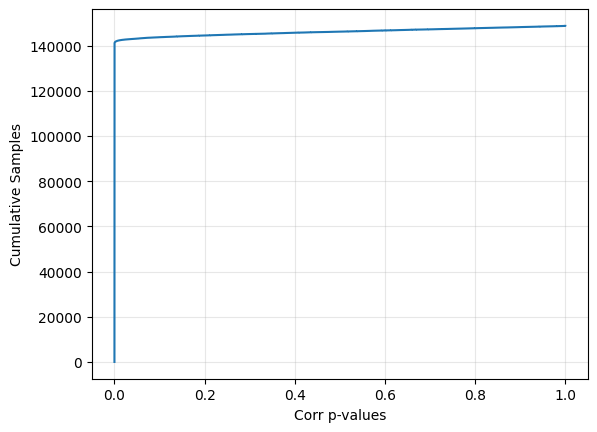

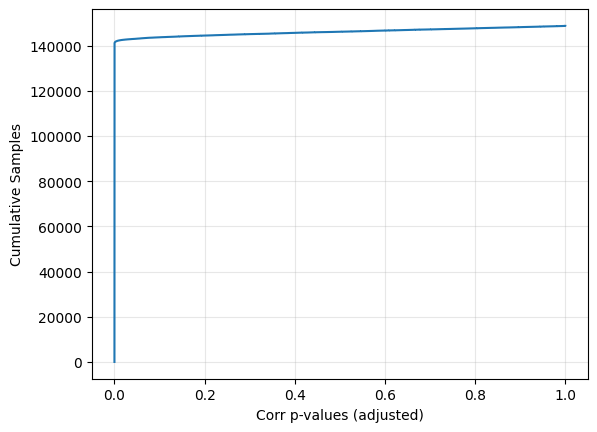

In [ ]:
corr_pvalues = corr_pvalue_matrix[np.triu_indices_from(corr_pvalue_matrix, k=1)]
corr_pvalues_adj = multipletests(corr_pvalues, method="fdr_bh", alpha=0.01)[1]

xs = np.sort(corr_pvalues)
ys = np.arange(1, xs.size + 1)

plt.figure()
plt.step(xs, ys, where="post")
# plt.axvline(corr_crit, linestyle="--")
plt.xlabel("Corr p-values")
plt.ylabel("Cumulative Samples")
plt.grid(True, alpha=0.3)
plt.show()

xs = np.sort(corr_pvalues_adj)
ys = np.arange(1, xs.size + 1)

plt.figure()
plt.step(xs, ys, where="post")
# plt.axvline(corr_crit, linestyle="--")
plt.xlabel("Corr p-values (adjusted)")
plt.ylabel("Cumulative Samples")
plt.grid(True, alpha=0.3)
plt.show()

### Bonferonni Test

Still not strict enough

In [197]:
num_tests = int((n**2)/2 - n/2) # Bonferonni Test
sig_level = 0.001 / num_tests
t_crit = t.ppf(1 - sig_level/2, df=n-2)
corr_crit = np.sqrt(t_crit**2 / (t_crit**2 + n-2))
print(f"|corr| is significant when >= {corr_crit}")

|corr| is significant when >= 0.15695379556332534


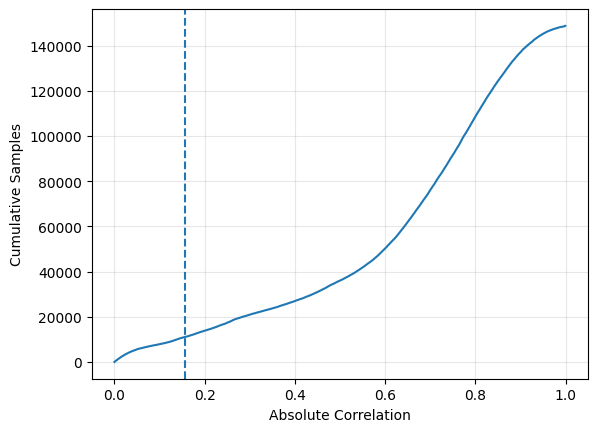

In [198]:
xs = np.sort(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]))
ys = np.arange(1, xs.size + 1)

plt.figure()
plt.step(xs, ys, where="post")
plt.axvline(corr_crit, linestyle="--") 
plt.xlabel("Absolute Correlation")
plt.ylabel("Cumulative Samples")
plt.grid(True, alpha=0.3)
plt.show()

## Cointegrated Pairs

- log P1 = c + lev * log P2 + error
- error_t = alpha * error_(t-1) + epsilon

Hypothesis Test
- H0: alpha = 1
- H1: alpha < 1 -> error is stationary -> P1 & P2 are cointegrated

In [ ]:
def test_coint_for_pair(i, j, data, keys, conf):
    y = data.iloc[:, i]
    x = data.iloc[:, j]
    # coint test - returns (t_stat, pvalue, crit_vals)
    stat, pvalue, _ = coint(y, x)
    return i, j, pvalue, (keys[i], keys[j]), (pvalue < conf)

def find_cointegrated_pairs_parallel(data, conf=0.05, n_jobs=-1):
    data = data.dropna()  # optional: ensures coint doesn't choke on NaNs
    n = data.shape[1]
    keys = list(data.columns)

    tuples = [(i, j) for i in range(n) for j in range(i+1, n)]

    res = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(test_coint_for_pair)(i, j, data, keys, conf)
        for i, j in tuples
    )

    pvalue_matrix = np.full((n, n), np.nan)
    # for i in range(n):
    #     pvalue_matrix[i,i] = 0
    pairs = []
    for i, j, pvalue, pair, is_coint in res:
        pvalue_matrix[i, j] = pvalue
        if not is_coint: 
            continue
        pairs.append(pair)
    return pvalue_matrix, pairs

In [ ]:
subset = log_price_df_train.iloc[:, :]
coint_pvalue_matrix, pairs = find_cointegrated_pairs_parallel(subset)

In [236]:
# fig = go.Figure(data=go.Heatmap(
#                    z=coint_pvalue_matrix,
#                    x=subset.columns, y=subset.columns,
#                    hoverongaps = False,
#                    zmin=0, zmax=1, colorscale="thermal_r",
# ))
# fig.update_layout(width=800,height=800)
# fig.show()

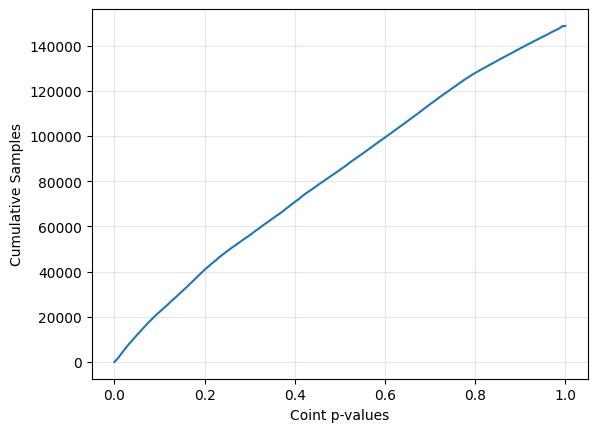

In [227]:
coint_pvalues = coint_pvalue_matrix[np.triu_indices_from(coint_pvalue_matrix, k=1)]

xs = np.sort(coint_pvalues)
ys = np.arange(1, xs.size + 1)

plt.figure()
plt.step(xs, ys, where="post")
plt.xlabel("Coint p-values")
plt.ylabel("Cumulative Samples")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
cols = list(subset.columns)
col_to_idx = {c:i for i,c in enumerate(cols)}

pairs_df = pd.DataFrame(pairs, columns=["y-sym","x-sym"])
pairs_df["y-name"] = pairs_df["y-sym"].map(sym2name)
pairs_df["x-name"] = pairs_df["x-sym"].map(sym2name)
pairs_df["coint-pvalue"] = pairs_df.apply(
    lambda r: coint_pvalue_matrix[col_to_idx[r["y-sym"]], col_to_idx[r["x-sym"]]],
    axis=1
)

pairs_df.head()

,y-sym,x-sym,y-name,x-name,coint-pvalue
0,DBP,XLF,Invesco DB Precious Metals Fund,State Street Financial Select Sector SPDR ETF,0.012016
1,FXF,KRE,Invesco CurrencyShares Swiss Franc Trust,State Street SPDR S&P Regional Banking ETF,0.030970
2,CEF,DXJ,Sprott Physical Gold and Silver Trust Units,WisdomTree Japan Hedged Equity Fund,0.002647
3,FXF,RFG,Invesco CurrencyShares Swiss Franc Trust,Invesco S&P MidCap 400 Pure Growth ETF,0.044758
4,FXF,SCC,Invesco CurrencyShares Swiss Franc Trust,ProShares UltraShort Consumer Discretionary,0.018839


## Gathering Pair Statistics

In [69]:
pairs_df = pd.read_csv('data/pairs_df.csv', usecols=['y-sym', 'x-sym', 'y-name', 'x-name', 'coint-pvalue'])
col_to_idx = {c:i for i,c in enumerate(log_price_df_train.columns)}

In [ ]:
def gather_stats(r):
    y_idx, x_idx = col_to_idx[r[0]], col_to_idx[r[1]]
    cor = corr_matrix[y_idx, x_idx]
    
    # OLS
    y = log_price_df_train.iloc[:, y_idx].to_numpy(dtype=float)
    x = log_price_df_train.iloc[:, x_idx].to_numpy(dtype=float)
    n = x.size
    x_mean = x.mean()
    y_mean = y.mean()
    dx = x - x_mean
    dy = y - y_mean
    ss_x = dx @ dx
    lev = (dx @ dy) / ss_x
    intercept = y_mean - lev * x_mean
    resid = dy - lev * dx
    ss_res = resid @ resid
    df = n-2
    mse = ss_res / df
    lev_stdev = np.sqrt(mse / ss_x)
    
    lev_stat = lev / lev_stdev
    # lev_pvalue = 2.0 * t.sf(np.abs(lev_stat), df)
    px_error_cor = np.corrcoef(resid, y)[0,1] # cor(resid, x) = 0
    resid_ret = np.diff(resid)
    y_ret_error_cor = np.corrcoef(resid_ret, np.diff(y))[0,1]
    x_ret_error_cor = np.corrcoef(resid_ret, np.diff(x))[0,1]
    ret_error_cor = y_ret_error_cor if abs(y_ret_error_cor) > abs(x_ret_error_cor) else x_ret_error_cor

    # Stationarity test
    y_stat, y_pval, y_usedlag, _, _, _ = adfuller(y, regression="c", autolag="AIC")
    x_stat, x_pval, x_usedlag, _, _, _ = adfuller(x, regression="c", autolag="AIC")
    station_stat = y_stat if abs(y_stat) > abs(x_stat) else x_stat
    station_pval = min(y_pval, x_pval)

    return lev_stat, intercept, lev, cor, px_error_cor, ret_error_cor, station_stat, station_pval

In [ ]:
res = Parallel(n_jobs=-1, verbose=0)(
    delayed(gather_stats)(r)
    for r in pairs_df.itertuples(index=False)
)
res = list(zip(*res))
for i, col in enumerate(['lev-stat', 'intercept', 'lev', 'cor', 'px_error_cor', 'ret_error_cor', 'station-stat', 'station-pvalue']):
    pairs_df[col] = res[i]
pairs_df = pairs_df.sort_values("cor", key=lambda s: abs(s)).reset_index(drop=True)
pairs_df

,y-sym,x-sym,y-name,x-name,coint-pvalue,lev-stat,intercept,lev,cor,px_error_cor,ret_error_cor,station-stat,station-pvalue
0,DBP,XLF,Invesco DB Precious Metals Fund,State Street Financial Select Sector SPDR ETF,0.012016,-66.975476,0.321275,-0.696400,0.000010,0.501470,0.808737,-1.257735,0.648280
1,FXF,KRE,Invesco CurrencyShares Swiss Franc Trust,State Street SPDR S&P Regional Banking ETF,0.030970,-13.021511,0.135804,-0.067784,0.000020,0.948085,0.991467,-3.142417,0.023569
2,CEF,DXJ,Sprott Physical Gold and Silver Trust Units,WisdomTree Japan Hedged Equity Fund,0.002647,-84.954622,0.291072,-0.977648,0.000021,0.415615,0.767507,-1.223104,0.663579
3,FXF,RFG,Invesco CurrencyShares Swiss Franc Trust,Invesco S&P MidCap 400 Pure Growth ETF,0.044758,-6.844593,0.136215,-0.042779,0.000026,0.984810,0.997802,-3.142417,0.023569
4,FXF,SCC,Invesco CurrencyShares Swiss Franc Trust,ProShares UltraShort Consumer Discretionary,0.018839,13.966198,0.148834,0.023309,0.000049,0.940957,0.998247,-3.142417,0.023569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,IYY,VTI,iShares Dow Jones U.S. ETF,Vanguard Total Stock Market ETF,0.041366,5871.460423,-0.000213,0.986418,0.996236,0.006612,0.077269,-1.489897,0.538503
11948,AGQ,SIVR,ProShares Ultra Silver,abrdn Physical Silver Shares ETF,0.008840,158.005829,-0.741661,2.576331,0.996814,0.238592,-0.959618,-1.254705,0.649632
11949,SIVR,SLV,abrdn Physical Silver Shares ETF,iShares Silver Trust,0.033142,5706.578077,0.008462,0.991104,0.997515,0.006803,0.180863,-1.254705,0.649632
11950,AGQ,SLV,ProShares Ultra Silver,iShares Silver Trust,0.008262,161.826531,-0.720639,2.556870,0.998252,0.233269,-0.972893,-1.231729,0.659800


In [71]:
pairs_df.to_csv('data/pairs_df.csv')